In [1]:
from eocene_creator import EoceneOIFS
import xarray as xr

eocene = EoceneOIFS(
    idir="/lus/h2resw01/hpcperm//ecme3497/ece4-database",
    odir="/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc",
    herold="/lus/h2resw01/hpcperm/ecme3497/herold-et-al-2014/Supp"
)

In [2]:
vegetation = xr.open_dataset(eocene.prepare_vegetation_zhang())
landsea =xr.open_dataset(eocene.prepare_herold(flag="landsea_mask"))
sd_orog = xr.open_dataset(eocene.prepare_herold(flag="sd_orography"))["sd_orography"]
sd_orog = sd_orog.fillna(0)
eocene.create_init(landsea=landsea['landsea_mask'], tvl=vegetation['tvl'], tvh=vegetation['tvh'], cvl=vegetation['cvl'], cvh=vegetation['cvh'], sd_orog=sd_orog)

Converting to netcdf file /lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/19900101/ICMGGECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/19900101/ICMGGECE4INIT using function replace_value
Replacing variable sdfor in the field
Converting back to GRIB file /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.2288646.20251028_131640.157/cdoPyi7r3h9mw
Converting to netcdf file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMGGECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMGGECE4INIT using function modify_value
Modifying variable anor in the field
Modifying variable isor in the field
Modifying variable slor in the field
Modifying variable cl in the field
Modifying variable chnk in the field
Converting back to GRIB file /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.2288646.20251028_131640.157/cdoPy13ha1_ai
Nullifying variable ['sd'] in GRIB file /lus/h2resw01/hpcperm/ecme3497/ece4-data

In [3]:
# Prepare the present-day land-sea mask
lsm_present = eocene.prepare_landsea_mask_present()

→ Reading land-sea mask from /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMGGECE4INIT
Land-sea mask prepared with shape (64, 128) and dims ('lat', 'lon')


In [4]:
landsea=landsea['landsea_mask']

In [5]:
eocene.create_climate(lsm_present, landsea)

Converting to netcdf file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/climate.v020/ICMCLECE4
Modifying GRIB file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/climate.v020/ICMCLECE4 using function albedo
Applying combined Albedo reconstruction + Eocene mask...
Albedo reconstruction complete.
Eocene land-sea mask applied successfully.
Combined modification complete, GRIB structure preserved.
Converting back to GRIB file /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.2288646.20251028_131640.157/cdoPyw_jcxzdl


/lus/h2resw01/hpcperm/ecme3497/github/ecearth-quests/epochal/OIFS/albedo.py:44: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ntime = field.dims["time"]


<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12, lon: 128, lat: 64)
Coordinates:
  * time     (time) object 96B 9999-01-15 00:00:00 ... 9999-12-15 00:00:00
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Data variables:
    al       (time, lat, lon) float32 393kB ...
    aluvp    (time, lat, lon) float32 393kB ...
    aluvd    (time, lat, lon) float32 393kB ...
    alnip    (time, lat, lon) float32 393kB ...
    alnid    (time, lat, lon) float32 393kB ...
    lai_lv   (time, lat, lon) float32 393kB ...
    lai_hv   (time, lat, lon) float32 393kB ...
Attributes:
    CDI:          Climate Data Interface version 2.5.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 28 15:56:53 2025: cdo -O -s -f nc4 -remapnn,N32 -se...
    CDO:          Climate Data Operators version 2.5.0 (https:

/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.2288646.20251028_131640.157/ipykernel_3894585/1615466590.py:35: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  icmcl_remap = xr.open_dataset("/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc")


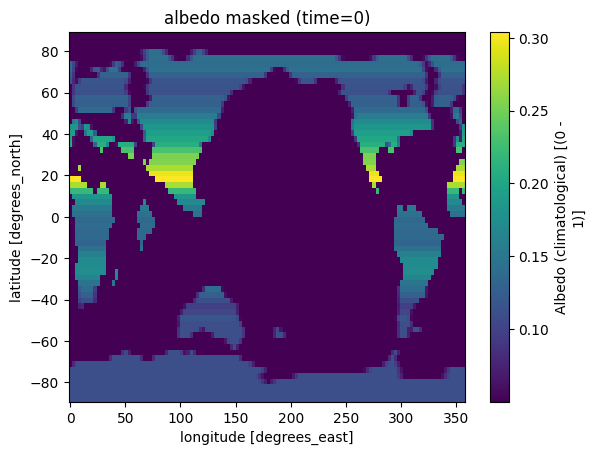

Temporary file 'ICMCLECE4_remap.nc' deleted successfully.


In [6]:
# 1- Load libraries
import os
import xarray as xr
import numpy as np
from cdo import Cdo
from utils import modify_value, replace_value
from utils import extract_grid_info, spectral2gaussian
import shutil
import tempfile
import matplotlib.pyplot as plt
from utils import GRIB2, NC4
cdo = Cdo()

icmcl_file = "/home/ecme3497/hpcperm/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4"
icmcl_remap = "/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc"

# 3- Grid configuration
resolution = "TL63L31"
kind, spectral, _ = extract_grid_info(resolution)
gaussian = spectral2gaussian(spectral, kind)

# 4- Transform GRIB to NetCDF
for infile, outfile in [(icmcl_file,
                         icmcl_remap)]:
    if os.path.exists(outfile):
        os.remove(outfile)
    cdo.remapnn(
        f"N{gaussian}",
        input=f"-setgridtype,regular {infile}",
        output=outfile,
        options="-f nc4"
    )

# 5- Abro el archivo icmcl remapeado 
icmcl_remap = xr.open_dataset("/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc") 

# Mostrar información general 
print(icmcl_remap)

icmcl_remap['al'].isel(time=5).plot(cmap='viridis')

plt.title("albedo masked (time=0)")
plt.show()

# Delete the temporary remapped file
os.remove("/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc")
print("Temporary file 'ICMCLECE4_remap.nc' deleted successfully.")

In [13]:
eocene.create_sic()
eocene.create_sst()

In [14]:

orog = xr.open_dataset(eocene.prepare_herold(flag="orography"))
eocene.create_sh(orog=orog['orography'], )

eocene.create_iniua()

Converting to netcdf file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMSHECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMSHECE4INIT using function replace_value
Replacing variable z in the field
Converting back to GRIB file /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1202079.20250528_120508.975/cdoPyctchtj1x
t,d,vo,lnsp
Converting to netcdf file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMGGECE4INIUA
Modifying GRIB file /lus/h2resw01/hpcperm//ecme3497/ece4-database/oifs/TL63L31/19900101/ICMGGECE4INIUA using function modify_value
Modifying variable q in the field
Converting back to GRIB file /etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1202079.20250528_120508.975/cdoPyg1neyl84


In [17]:
orog = xr.open_dataset(os.path.join(herold_dir, 'orography_remap.nc'))
landsea = xr.open_dataset(os.path.join(herold_dir, 'landsea_mask_remap.nc'))

In [19]:

def generate_seasonal_sst(inputfile, outputfile, A=25, OFFSET=20, T0=5):
    """
    Generate a seasonal SST latitudinal pattern and save it to a netCDF file.
    Parameters:
    - inputfile: Path to the input netCDF file.
    - outputfile: Path to the output netCDF file.
    - A: Amplitude of the latitudinal SST pattern.
    - OFFSET: Phase offset in degree for the seasonal pattern.
    - T0: Mean temperature.
    """

    sstfield = xr.open_dataset(inputfile)
    sstfield['tosbcs'].shape
    lons = sstfield['lon'].values
    lats = sstfield['lat'].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    # Sinusoidal parameters
    A = 25        # Amplitude in degrees Celsius
    #B = 5      # Amplitude in degrees Celsius
    #beta = 45    # Phase shift in degrees
    k_lat = np.pi / 180    # frequency in lat direction
    #k_lon = np.pi / 180 * 4    # frequency in lon direction
    T0 = 5       # Mean temperature
    OFFSET = 20

    seasonal = np.cos(np.linspace(0,2*np.pi,num=13))[:-1]* OFFSET

    # Create sinusoidal SST pattern
    sst_pattern = []
    for phasing in seasonal:
        sst_pattern.append(A * np.pow(np.cos(k_lat * lat2d + np.pi/180* phasing), 2) + T0) #+ B * np.sin(k_lon * lon2d + np.pi/180*beta) + T0
    sst_stack = np.stack(sst_pattern, axis=0)
    stacksize = sstfield['tosbcs'].shape[0]
    sst_broadcast = np.tile(sst_stack, ((stacksize+11)//12, 1, 1))[:stacksize]
    sstfield['tosbcs'].data = sst_broadcast
    #sst_broadcast = np.broadcast_to(sst_stack, sstfield['tosbcs'].shape)
    #(sstfield['tosbcs'].isel(time=6)-sstfield['tosbcs'].isel(time=0)).plot()
    if os.path.exists(outputfile):
        os.remove(outputfile)
    sstfield.to_netcdf(outputfile)

generate_seasonal_sst(
    inputfile=os.path.join(amip_indir, 'tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc'),
    outputfile=os.path.join(amip_outdir, 'tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc')
)


In [ ]:

# erase all orography
modify_single_grib(
    inputfile=os.path.join(indir,'ICMSHECE4INIT'),
    outputfile=os.path.join(outdir,'ICMSHECE4INIT'),
    variables='z',
    spectral=True,
    myfunction=replace_value,
    newfield=orog['orography']*9.81
    #myfunction=modify_value,
    #new_value=0. 
)

# truncate spectral variables to first harmonic (mean value)
truncate_grib_file(
    inputfile=os.path.join(outdir,'ICMSHECE4INIT'),
    variables=['t','d','vo','lnsp'],
    outputfile=os.path.join(outdir,'ICMSHECE4INIT'),
)

# erase all subgrid orography
modify_single_grib(
    inputfile=os.path.join(indir,'ICMGGECE4INIT'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIT_temp'),
    variables=['anor', 'isor', 'slor', 'cl', 'chnk'],
    spectral=False,
    myfunction=modify_value,
    newvalue=0.  
)

# erase all subgrid orography
modify_single_grib(
    inputfile=os.path.join(outdir,'ICMGGECE4INIT_temp'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIT_temp1'),
    variables=['slt'],
    spectral=False,
    myfunction=modify_value,
    newvalue=3 
)

modify_single_grib(
    inputfile=os.path.join(outdir,'ICMGGECE4INIT_temp1'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIT'),
    variables=['lsm'],
    spectral=False,
    myfunction=replace_value,
    newfield=landsea['landsea_mask']
)

# set humidity to 0
# swlv1, swvl2, swvl3, swvl4 to be set 0
#
modify_single_grib(
    inputfile=os.path.join(indir,'ICMGGECE4INIUA'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIUA'),
    variables='q',
    spectral=False,
    myfunction=modify_value,
    newvalue=0.  
)





Converting to netcdf file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMSHECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMSHECE4INIT using function replace_value
Replacing variable z in the field
Converting back to GRIB file /lus/h2resw01/scratch/ccpd/cdoPye2wmemal
t,d,vo,lnsp
Converting to netcdf file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT using function modify_value
Modifying variable sdor in the field
Modifying variable anor in the field
Modifying variable isor in the field
Modifying variable slor in the field
Modifying variable cl in the field
Modifying variable chnk in the field
Modifying variable tvh in the field
Modifying variable tvl in the field
Modifying variable cvh in the field
Modifying variable cvl in the field
Converting back to GRIB file /lus/h2resw01/scratch/ccpd/cdoPyimakj1r9
Convertin

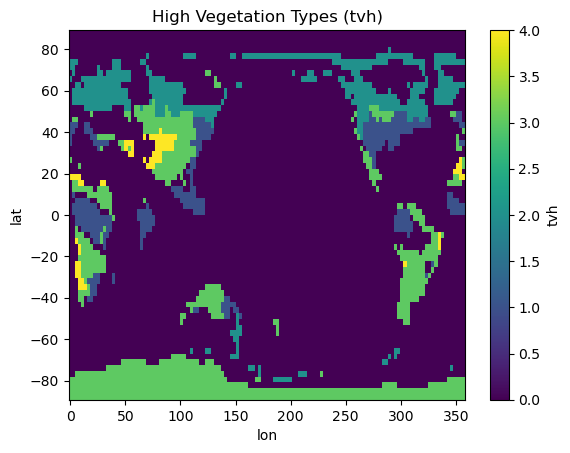

In [12]:
import matplotlib.pyplot as plt
veg = xr.open_dataset('/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/19900101/ICMGG_vegetation.nc')
veg['tvh'].plot()
plt.title('High Vegetation Types (tvh)')
plt.show()